In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Found 18713 files belonging to 7 classes.
Found 3217 files belonging to 7 classes.
Epoch 1/100
293/293 [==============================] - 26s 83ms/step - loss: 1.8497 - accuracy: 0.2609 - val_loss: 1.8954 - val_accuracy: 0.1989
Epoch 2/100
293/293 [==============================] - 24s 81ms/step - loss: 1.8595 - accuracy: 0.2695 - val_loss: 1.9459 - val_accuracy: 0.1750
Epoch 3/100
293/293 [==============================] - 24s 82ms/step - loss: 1.9459 - accuracy: 0.2390 - val_loss: 1.9459 - val_accuracy: 0.1750
Epoch 4/100
293/293 [==============================] - 24s 82ms/step - loss: 1.9459 - accuracy: 0.2356 - val_loss: 1.9459 - val_accuracy: 0.1750
Epoch 5/100
293/293 [==============================] - 24s 82ms/step - loss: 1.9459 - accuracy: 0.2377 - val_loss: 1.9459 - val_accuracy: 0.1750
Epoch 6/100
293/293 [==============================] - 24s 82ms/step - loss: 1.9461 - accuracy: 0.2519 - val_loss: 1.9459 - val_accuracy: 0.2048
Epoch 7/100
293/293 [==========================

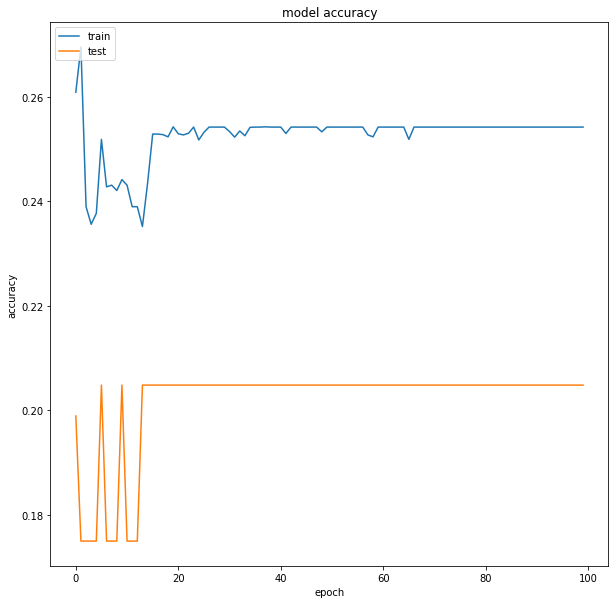

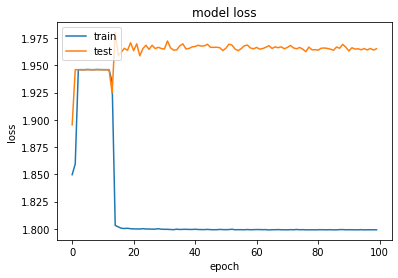


Total Training Time for the model:  0h 40m 58s


In [5]:
# Project - SqueezeNet
# Fire module adapted from: https://www.kaggle.com/code/whoiskk/squeezenet-tf-keras/notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Layer, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from keras.models import Model
from google.colab import drive, files
import os

import time, datetime

start = datetime.datetime.now()

time.sleep(10)

# /content/drive/MyDrive/Mura Dataset (50% Training Data, 100% Test data)/MURA-v1.1/train
# train_data_dir = '/content/drive/MyDrive/MURA-v1.1/train-100'


train_data_dir='/content/drive/MyDrive/Mura Datase_50%_Training Data_100%_Test data/MURA-v1.1/train'

#image_count_train = len(os.listdir('/content/drive/MyDrive/MURA-v1.1/train/'))

# test_data_dir = '/content/drive/MyDrive/MURA-v1.1/valid-100'
test_data_dir = '/content/drive/MyDrive/Mura Datase_50%_Training Data_100%_Test data/MURA-v1.1/valid'


#image_count_test = len(os.listdir('/content/drive/MyDrive/MURA-v1.1/valid/'))
batch_size = 64
img_height = 256
img_width = 256
trainX = tf.keras.utils.image_dataset_from_directory(train_data_dir, seed=123, image_size=(img_height, img_width), batch_size=batch_size)
testX = tf.keras.utils.image_dataset_from_directory(test_data_dir, seed=123, image_size=(img_height, img_width), batch_size=batch_size)
classes = trainX.class_names
plt.figure(figsize=(10, 10))

class FireModule(object):

    def __init__(self, layer_number: int, activation: str, kernel_initializer: str) -> None:
        self.layer_number = layer_number
        self.activation = activation
        self.kernel_initializer = kernel_initializer

    def build_module(self, fire_input: Layer) -> Layer:
        output_size = 128 * (1 + (self.layer_number // 2))
        squeeze_1x1_filters = 16 * (1 + (self.layer_number // 2))
        expand_1x1_filters = expand_3x3_filters = output_size // 2
        squeeze_1x1 = Conv2D(name=f'fire_{self.layer_number + 2}_squeeze_1x1', filters=squeeze_1x1_filters, kernel_size=(1, 1), strides=1, padding='valid', activation=self.activation, kernel_initializer=self.kernel_initializer)(fire_input)
        expand_1x1 = Conv2D(name=f'fire_{self.layer_number + 2}_expand_1x1', filters=expand_1x1_filters, kernel_size=(1, 1), strides=1, padding='valid', activation=self.activation, kernel_initializer=self.kernel_initializer)(squeeze_1x1)
        expand_3x3 = Conv2D(name=f'fire_{self.layer_number + 2}_expand_3x3', filters=expand_3x3_filters, kernel_size=(3, 3), strides=1, padding='same', activation=self.activation, kernel_initializer=self.kernel_initializer)(squeeze_1x1)
        fire = Concatenate(name=f'fire_{self.layer_number + 2}')([expand_1x1, expand_3x3])
        return fire

def squeezenet(in_shape=(256, 256, 3)):
    inp = layers.Input(in_shape)
    conv_1 = Conv2D(name="Conv_1", filters=96, kernel_size=(7, 7), strides=2, padding='same', activation='relu', kernel_initializer='glorot_uniform')(inp)
    maxpool_1 = MaxPool2D(name="MaxPool_1", pool_size=(3, 3), strides=2)(conv_1)
    fire_2 = FireModule(layer_number=0, activation='relu', kernel_initializer='glorot_uniform').build_module(maxpool_1)
    fire_3 = FireModule(layer_number=1, activation='relu', kernel_initializer='glorot_uniform').build_module(fire_2)
    fire_4 = FireModule(layer_number=2, activation='relu', kernel_initializer='glorot_uniform').build_module(fire_3)
    maxpool_2 = MaxPool2D(name="MaxPool_2", pool_size=(3, 3), strides=2)(fire_4)
    fire_5 = FireModule(layer_number=3, activation='relu', kernel_initializer='glorot_uniform').build_module(maxpool_2)
    fire_6 = FireModule(layer_number=4, activation='relu', kernel_initializer='glorot_uniform').build_module(fire_5)
    fire_7 = FireModule(layer_number=5, activation='relu', kernel_initializer='glorot_uniform').build_module(fire_6)
    fire_8 = FireModule(layer_number=6, activation='relu', kernel_initializer='glorot_uniform').build_module(fire_7)
    maxpool_3 = MaxPool2D(name="MaxPool_3", pool_size=(3, 3), strides=2)(fire_8)
    fire_9 = FireModule(layer_number=7, activation='relu', kernel_initializer='glorot_uniform').build_module(maxpool_3)
    dropout = Dropout(0.5, name="Dropout")(fire_9)
    conv_10 = Conv2D(name="Conv_10", filters=1000, kernel_size=(1, 1), strides=1, padding='valid', activation='relu', kernel_initializer='glorot_uniform')(dropout)
    final = GlobalAveragePooling2D()(conv_10)
    mod = Model(inp, final)
    return mod

model = squeezenet()
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(trainX, validation_data=testX, epochs=100)
print (history.history.keys())



plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./accuracy per epochs for SqueezeNet-graph.jpg")
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./loss per epochs for SqueezeNet-graph.jpg")
plt.show()






end = datetime.datetime.now()
diff = (end - start)
datetime.timedelta(seconds=10, microseconds=885206)


diff_seconds = int(diff.total_seconds())
minute_seconds, seconds = divmod(diff_seconds, 60)
hours, minutes = divmod(minute_seconds, 60)
hms = f"{hours}h {minutes}m {seconds}s"
print("\nTotal Training Time for the model: ", hms)
